# Adiabatic combustion of acetylene

Acetylene (C$_2$H$_2$) gas is combusted with 110% theoretical air in a torch at atmospheric pressure; both the acetylene and air are supplied at 25°C. The torch is adiabatic and the products emerge at a high temperature and atmospheric pressure.

At high temperatures, nitrogen can dissociate, and the resulting nitrogen radical can react with oxygen to form nitrogen oxides (NO and NO$_2$).

In addition, the acetylene could be converted to C$_2$H$_4$ or CH$_4$.

Thus, at equilibrium, the gases that may be present include C$_2$H$_2$, C$_2$H$_4$, CH$_4$, CO, CO$_2$, H$_2$ H$_2$O, O$_2$, N$_2$, NO, and NO$_2$.

**Problem:**

- Find the temperature and composition of the products, assuming the reaction proceeds to completion.
- Find the temperature and composition of the products, assuming that the reaction(s) proceed to the equilibrium condition.
- Compare the adiabatic flame temperatures calculated using complete combustion and chemical equilibrium, for a range of theoretical air values between 0.75 and 2.0.

In [30]:
import numpy as np
import cantera as ct
from scipy.optimize import root, root_scalar

from pint import UnitRegistry
ureg = UnitRegistry()
Q_ = ureg.Quantity

# for convenience:
def to_si(quant):
    '''Converts a Pint Quantity to magnitude at base SI units.
    '''
    return quant.to_base_units().magnitude

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

# these are mostly for making the saved figures nicer
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'png')
plt.rcParams['figure.dpi']= 300
plt.rcParams['savefig.dpi'] = 300

In [32]:
# given data

temperature_initial = Q_(25, 'degC').to('K')
pressure = Q_(1, 'atm')

theoretical_air = 1.1

## Complete combustion products

To determine the composition and temperature of the products, assuming the combustion of acetylene proceeds to completion, we need to:

1. Determine the stoichiometric coefficients of the products for stoichiometric, rich (excess fuel), and lean (excess air) mixtures; this will give the composition of the products based on the initial composition.
2. Perform an energy balance on the system, which we can use to determine the unknown final temperature.

The stoichiometric reaction of acetylene in air, assuming complete combustion, is

$$
\text{C}_2 \text{H}_2 + a_s \left( 0.21 \text{O}_2 + 0.79 \text{N}_2 \right) \leftrightarrow b_s \text{CO}_2 + c_s \text{H}_2 \text{O} + d_s \text{N}_2
$$

In [33]:
def get_stoich_coeffs(x):
    """Calculate coefficients for stoichiometric reaction"""
    a_s, b_s, c_s, d_s = x
    return [
        2 - b_s, # carbon balance
        2 - 2 * c_s, # hydrogen balance
        2 * 0.21 * a_s - (2 * b_s + c_s), # oxygen balance
        2 * 0.79 * a_s - 2 * d_s, # nitrogen balance
    ]

In [34]:
sol = root(get_stoich_coeffs, [1, 1, 1, 1])
coeffs_stoich = sol.x

For varying amounts of air, the complete combustion reaction is

$$
\text{C}_2 \text{H}_2 + a \left( 0.21 \text{O}_2 + 0.79 \text{N}_2 \right) \leftrightarrow b \text{CO}_2 + c \text{H}_2 \text{O} + d \text{N}_2 + e \text{O}_2 + f \text{C}_2 \text{H}_2
$$

When the theoretical air is < 1 (i.e., the mixture is rich), then there will be leftover fuel in the products but no oxygen; when the theoretical air is > 1 (i.e., the mixture is lean), then there will be leftover oxygen in the products but no fuel.
If the theoretical air is = 1, then there will be no leftover oxygen or fuel in the products.

We can design a function to solve for the complete combustion coefficients in any of these cases:

In [35]:
def get_coeffs(x, theoretical_air, coeffs_stoich_air):
    """Calculate coefficients for complete combustion"""
    a, b, c, d, e, f = x
    
    equations = [
        a - theoretical_air * coeffs_stoich_air, # theoretical air
        2 - (b + 2 * f), # carbon
        2 - (2 * c + 2 * f), # hydrogen
        0.79 * 2 * a - 2 * d, # nitrogen
    ]
    
    # If rich, no oxygen remaining.
    # If lean, no fuel remaining.
    # If balanced, no oxygen or fuel remaining
    if theoretical_air < 1.0:
        equations += [
            0.21 * 2 * a - (2 * b + c + 2 * e), # oxygen
            e,
        ]
    elif theoretical_air > 1.0:
        equations += [
            0.21 * 2 * a - (2 * b + c + 2 * e), # oxygen
            f,
        ]
    else:
        equations += [
            f,
            e,
        ]
    
    return equations

In [36]:
# calculate coefficients for this particular case

coeffs_stoich_air = coeffs_stoich[0]

sol = root(
    get_coeffs, 
    [1, 1, 1, 1, 1, 0], 
    args=(theoretical_air, coeffs_stoich_air)
    )

coeffs = sol.x
# contents: coefficients of air, CO2, H2O, N2, O2, C2H2

In [37]:
# Get all of the Species objects defined in the GRI 3.0 mechanism
species = {S.name: S for S in ct.Species.list_from_file('gri30.yaml')}

# Create an IdealGas object with species representing complete combustion
complete_species = ['C2H2', 'O2', 'N2', 'CO2', 'H2O']
gas = ct.Solution(
    thermo='IdealGas', 
    species=[species[S] for S in complete_species]
    )

In [38]:
def get_temperature_complete(temperature, temperature_initial, 
                             pressure, coeffs, gas
                             ):
    """Calculate adiabatic flame temperature for complete combustion"""    
    # reactants
    gas.TPX = to_si(temperature_initial), to_si(pressure), 'C2H2:1.0'
    enthalpy_c2h2 = gas.enthalpy_mole
    
    # only change the composition
    gas.TPX = None, None, 'O2:1.0'
    enthalpy_o2 = gas.enthalpy_mole

    gas.TPX = None, None, 'N2:1.0'
    enthalpy_n2 = gas.enthalpy_mole
    
    enthalpy_reactants = (
        enthalpy_c2h2 + 
        coeffs[0] * (0.21 * enthalpy_o2 + 0.79 * enthalpy_n2)
    )
    
    # products
    gas.TPX = temperature, to_si(pressure), 'C2H2:1.0'
    enthalpy_c2h2 = gas.enthalpy_mole

    gas.TPX = None, None, 'O2:1.0'
    enthalpy_o2 = gas.enthalpy_mole

    gas.TPX = None, None, 'N2:1.0'
    enthalpy_n2 = gas.enthalpy_mole
    
    gas.TPX = None, None, 'CO2:1.0'
    enthalpy_co2 = gas.enthalpy_mole
    
    gas.TPX = None, None, 'H2O:1.0'
    enthalpy_h2o = gas.enthalpy_mole
    
    enthalpy_products = (
        coeffs[1] * enthalpy_co2 + coeffs[2] * enthalpy_h2o +
        coeffs[3] * enthalpy_n2 + coeffs[4] * enthalpy_o2 + 
        coeffs[5] * enthalpy_c2h2
        )
    
    return enthalpy_reactants - enthalpy_products

In [39]:
sol = root_scalar(
    get_temperature_complete, 
    x0=2000, x1=3000,
    args=(temperature_initial, pressure, coeffs, gas)
    )
print(f'Temperature (complete combustion): {sol.root: .1f} K')

moles_products = (
    coeffs[1] + coeffs[2] + coeffs[3] + coeffs[4] + coeffs[5]
    )
mole_fractions = coeffs[1:] / moles_products
print('Mole fractions in products:')
print(f'CO2: {mole_fractions[0]: .3f}')
print(f'H2O: {mole_fractions[1]: .3f}')
print(f'N2: {mole_fractions[2]: .3f}')
print(f'O2: {mole_fractions[3]: .3f}')
print(f'C2H2: {mole_fractions[4]: .3f}')

Temperature (complete combustion):  2720.2 K
Mole fractions in products:
CO2:  0.147
H2O:  0.074
N2:  0.761
O2:  0.018
C2H2:  0.000


In [40]:
# Calculate final temperature for range of theoretical air

theoretical_airs_complete = np.linspace(0.75, 2.0, 51)
temperatures_complete = np.zeros(len(theoretical_airs_complete))

for idx, theoretical_air in enumerate(theoretical_airs_complete):
    # get species coefficients
    sol = root(get_coeffs, 
               [1, 1, 1, 1, 1, 0], 
               args=(theoretical_air, coeffs_stoich_air)
                )
    coeffs = sol.x
    
    # get temperature
    sol = root_scalar(
        get_temperature_complete, 
        x0=2000, x1=3000,
        args=(temperature_initial, pressure, coeffs, gas)
        )
    
    temperatures_complete[idx] = sol.root

## Equilibrium products

Now, we need to consider all the possible gases that could be present in the products when the mixture has reached chemical equilibrium.

To find the amounts of each gas and the temperature, we'll need to use the Lagrange method of undetermined multipliers.

In [41]:
# species that may be present in products at equilibrium
species_list = [
    'C2H2', 'O2', 'N2', 'H2O', 'CO2', 
    'CH4', 'C2H4', 'CO', 'H2', 'NO', 'NO2',
    ]

# Get all of the Species objects defined in the GRI 3.0 mechanism
species = {S.name: S for S in ct.Species.list_from_file('gri30.yaml')}

# Create an IdealGas object with all species involved
gas = ct.Solution(
    thermo='IdealGas', 
    species=[species[S] for S in species_list]
    )

# Elemental makeup of components
elemental_comp = np.array([
    [2, 0, 0, 2, 0, 4, 4, 0, 2, 0, 0], # hydrogen
    [0, 2, 0, 1, 2, 0, 0, 1, 0, 1, 2], # oxygen
    [0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 1], # nitrogen
    [2, 0, 0, 0, 1, 1, 2, 1, 0, 0, 0], # carbon
    ])

theoretical_air = 1.1

moles_initial = np.zeros(len(species_list))
moles_initial[0] = 1.0
moles_initial[1] = coeffs_stoich_air * theoretical_air * 0.21
moles_initial[2] = coeffs_stoich_air * theoretical_air * 0.79

In [42]:
def lagrange_system(x, temperature_initial, pressure, components, gas, 
                    elemental_comp, moles_initial
                    ):
    '''System of equations for reaction coordinate and equilibrium composition.
    '''
    num_components = len(components)
    
    moles = x[0 : num_components]
    multipliers = x[num_components : -1]
    temperature = x[-1]
    
    mole_fractions = moles / np.sum(moles)
    
    # get standard-state Gibbs free energy and enthalpy of each component
    gibbs = np.zeros(len(components))
    enthalpies_final = np.zeros(len(components))
    enthalpies_initial = np.zeros(len(components))
    for idx, comp in enumerate(components):
        gas.TPX = (
            temperature, ct.one_atm,
            f'{comp}:1.0'
            )
        gibbs[idx] = gas.gibbs_mole
        enthalpies_final[idx] = gas.enthalpy_mole
        
        gas.TPX = (
            to_si(temperature_initial), ct.one_atm,
            f'{comp}:1.0'
            )
        enthalpies_initial[idx] = gas.enthalpy_mole
    
    # Calculate the chemical potentials at current pressure and temperature
    gas_constant = ct.gas_constant
    chemical_potentials = (
        gibbs + gas_constant * temperature * np.log(
            mole_fractions * to_si(pressure) / ct.one_atm
            )
        )
    
    # molar amounts of each element
    # base SI units are in mol, not kmol, after conversion
    initial_moles_elements = np.dot(elemental_comp, moles_initial)
    moles_elements = np.dot(elemental_comp, moles)
    
    enthalpy_initial = np.dot(moles_initial, enthalpies_initial)
    enthalpy_final = np.dot(moles, enthalpies_final)
    
    # We can take advantage of element-wise operations with these arrays,
    # and concisely evaluate all the equations
    element_equations = moles_elements - initial_moles_elements
    multiplier_equations = (
        chemical_potentials + 
        np.dot(multipliers, elemental_comp)
        )
    
    # Return the set of equations joined together
    #
    # The equations for the multipliers and enthalpy are scaled
    # to match the order of magnitude of the moles
    return np.concatenate((
        element_equations, multiplier_equations / 1e8, 
        [(enthalpy_final - enthalpy_initial) / 1e8]
        ))

In [43]:
# initial guesses
x0 = [0.5] * len(species_list) + [1e8, 1e8, 1e8, 1e8, 2500]

sol = root(
    lagrange_system, x0, method='lm', 
    args=(temperature_initial, pressure, species_list, gas,
          elemental_comp, moles_initial
          ),
    options={'maxiter': 5000},
    )
    
temperature_final = Q_(sol.x[-1], 'K')
print(f'Temperature (equilibrium): {temperature_final: .2f}')

moles = sol.x[0 : len(species_list)]
mole_fractions = moles / sum(moles)

print('Mole fractions in products:')
for sp, val in zip(species_list, mole_fractions):
    print(f'{sp}: {val: .3f}')

/var/folders/ng/d9rd9fb92c7bxz9fy7vwpj7m0000gp/T/ipykernel_51350/570880187.py:35: RuntimeWarning: invalid value encountered in log
  gibbs + gas_constant * temperature * np.log(


Temperature (equilibrium): 2507.34 kelvin
Mole fractions in products:
C2H2:  0.000
O2:  0.029
N2:  0.746
H2O:  0.070
CO2:  0.118
CH4:  0.000
C2H4:  0.000
CO:  0.027
H2:  0.003
NO:  0.008
NO2:  0.000


Comparing with the results found assuming complete combustion, we see that the temperature is lower, and we have a noticeable amount of CO in the products, along with some H$_2$ and NO.

The temperature is lower than the complete-combustion temperature mostly due to the presence of CO in the products; CO oxidation into CO$_2$ is responsible for much of the heat release in combustion.

In [54]:
# calculate for range of theoretical air

theoretical_airs = np.linspace(0.75, 2.0, 21)
temperatures = np.zeros(len(theoretical_airs))

for idx, theoretical_air in enumerate(theoretical_airs):
    moles_initial = np.zeros(len(species_list))
    moles_initial[0] = 1.0
    moles_initial[1] = coeffs_stoich_air * theoretical_air * 0.21
    moles_initial[2] = coeffs_stoich_air * theoretical_air * 0.79
    
    x0 = [0.5] * len(species_list) + [1e8, 1e8, 1e8, 1e8, 2500]

    sol = root(
        lagrange_system, x0, method='lm', 
        args=(temperature_initial, pressure, species_list, gas,
              elemental_comp, moles_initial
              ),
        options={'maxiter': 5000},
        )
    
    temperatures[idx] = sol.x[-1]

/var/folders/ng/d9rd9fb92c7bxz9fy7vwpj7m0000gp/T/ipykernel_51350/570880187.py:35: RuntimeWarning: invalid value encountered in log
  gibbs + gas_constant * temperature * np.log(


We can also use Cantera's equilibrium solver to find the final temperature; this should produce very similar values found using the Lagrange method.

In [55]:
theoretical_airs_ct = np.linspace(0.75, 2.0, 11)
temperatures_cantera = np.zeros(len(theoretical_airs_ct))

for idx, theoretical_air in enumerate(theoretical_airs_ct):
    moles_initial = np.zeros(len(species_list))
    moles_initial[1] = coeffs_stoich_air * theoretical_air * 0.21
    moles_initial[2] = coeffs_stoich_air * theoretical_air * 0.79
    
    gas.TPX = (
        to_si(temperature_initial), to_si(pressure),
        'C2H2: 1.0, '
        f'O2: {coeffs_stoich_air * theoretical_air * 0.21: .3f}, '
        f'N2: {coeffs_stoich_air * theoretical_air * 0.79: .3f}'
        )

    gas.equilibrate('HP')
    temperatures_cantera[idx] = gas.T

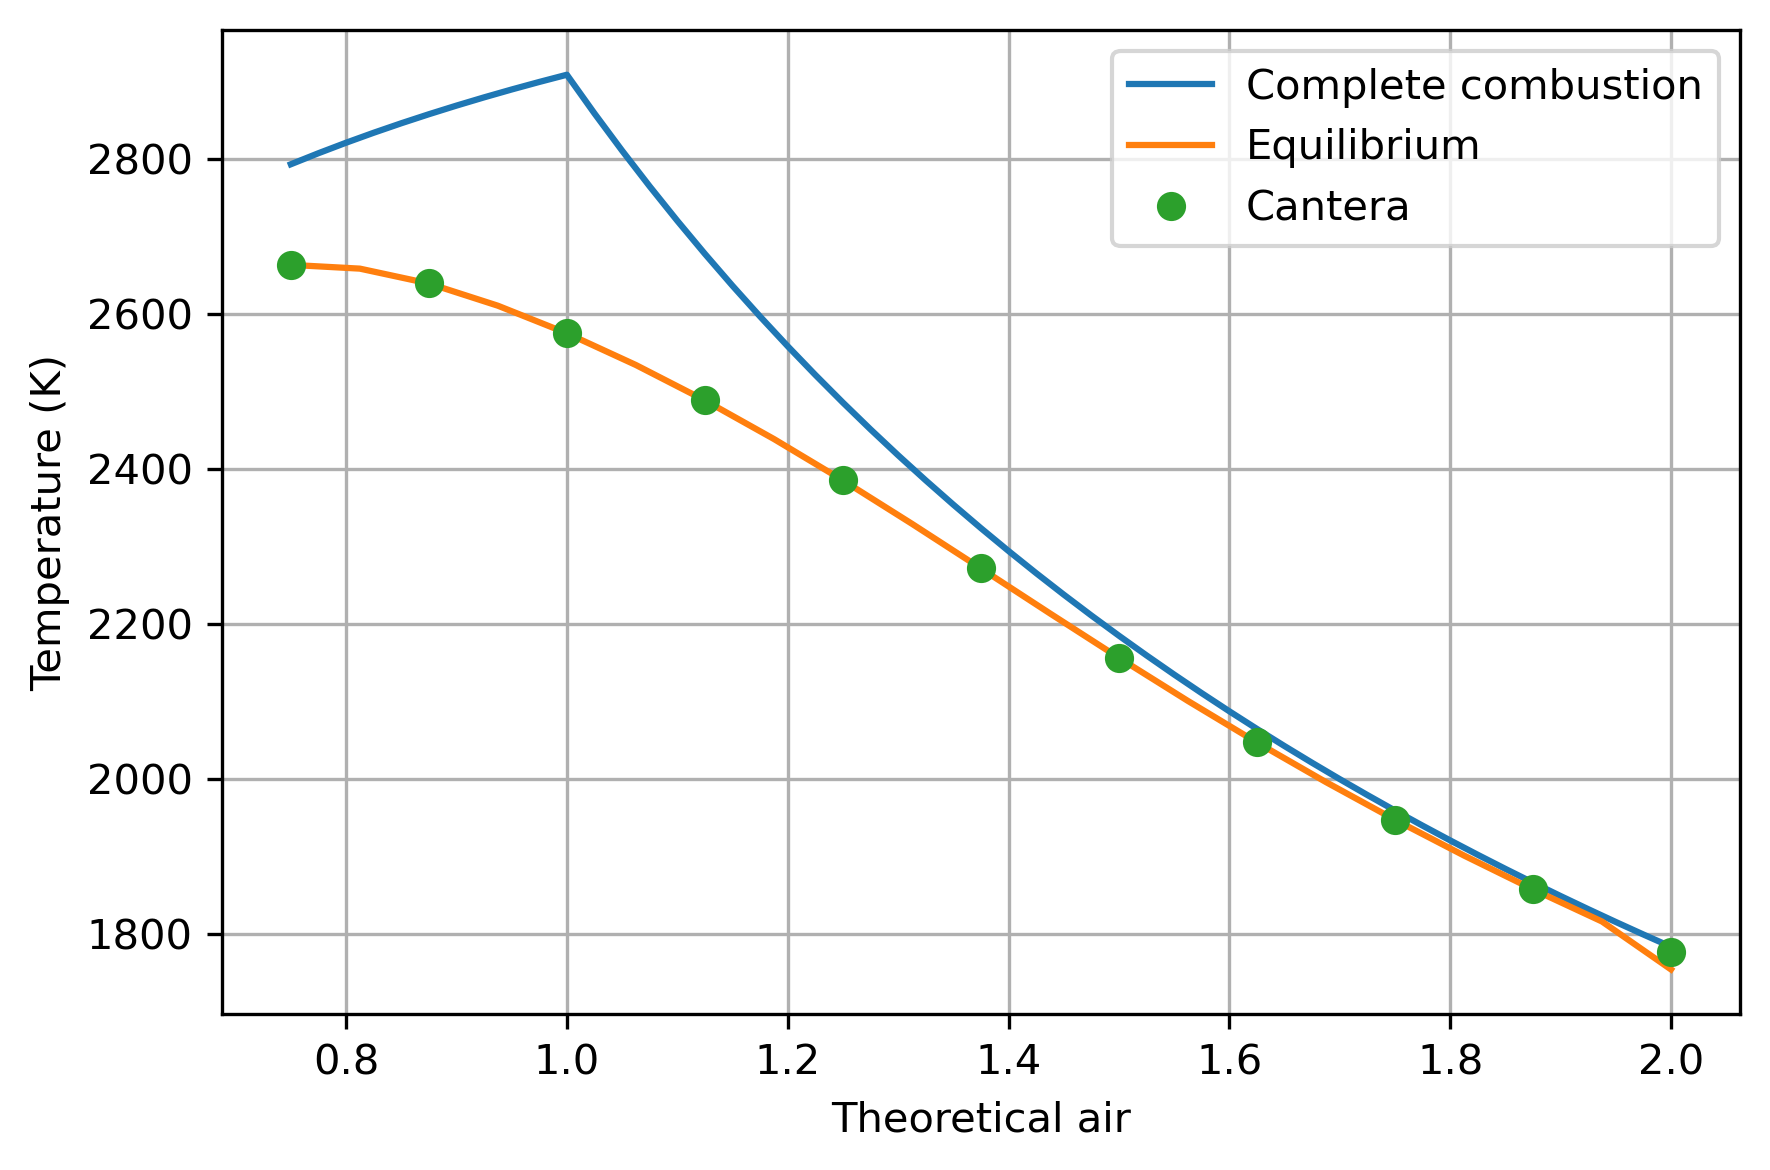

In [56]:
plt.plot(
    theoretical_airs_complete, temperatures_complete, 
    label='Complete combustion'
    )
plt.plot(
    theoretical_airs, temperatures, 
    label='Equilibrium'
    )
plt.plot(
    theoretical_airs_ct, temperatures_cantera, 'o', 
    label='Cantera'
    )

plt.xlabel('Theoretical air')
plt.ylabel('Temperature (K)')

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

As expected, the equilibrium calculations based on the Lagrange multiplier method and Cantera agree very closely, while the complete-combustion calculation differs significantly at lower values of excess air.

All three methods agree fairly well at higher percentages of excess air, because more excess air leads to smaller production of carbon monoxide and hydrogen.